# Fourier analysis

空間周波数領域におけるフーリエ解析を可視化

./visualize_fourier_analysis/trial_wellplate_epoch100_batch28/U2OS_48h/r01c06f06p01
5
5
r01c06f06p01_channel_ch1
61.46669639666753


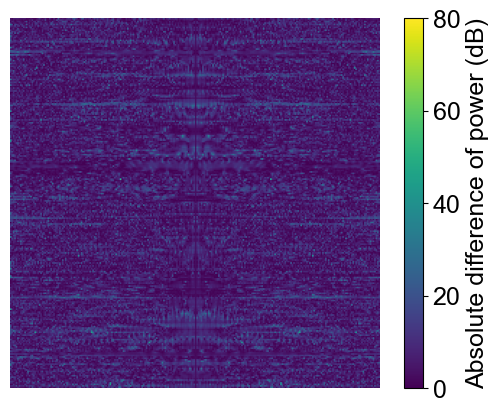

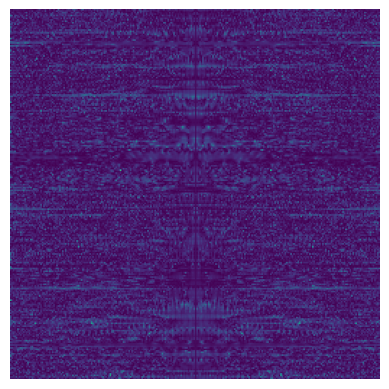

r01c06f06p01_channel_ch2
55.97405569269176


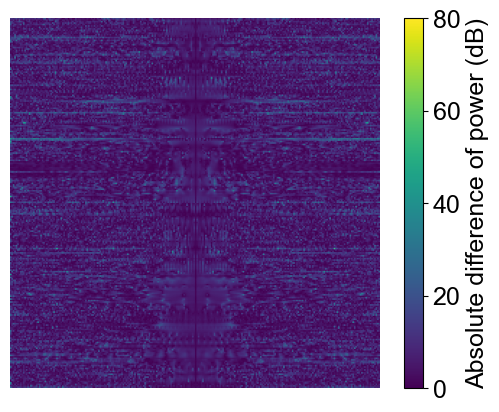

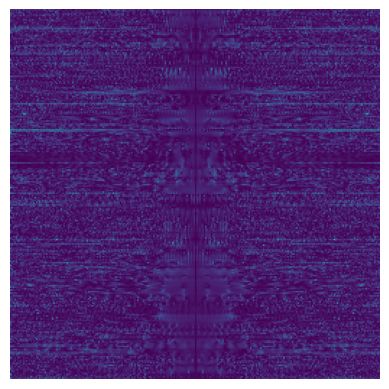

r01c06f06p01_channel_ch3
66.74095170838326


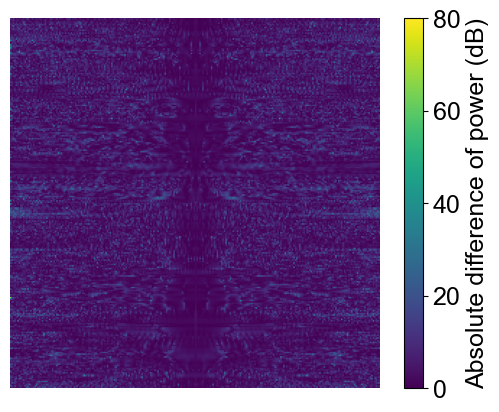

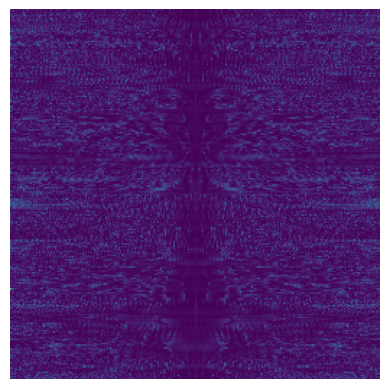

r01c06f06p01_channel_ch4
52.6974583459307


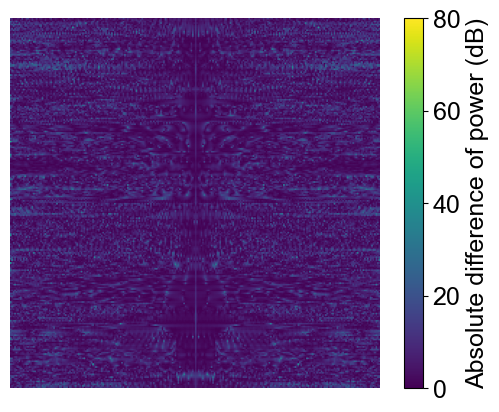

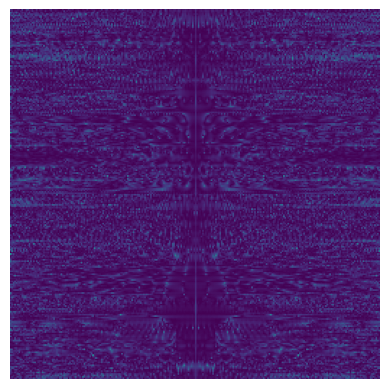

r01c06f06p01_channel_ch5
52.63498782087399


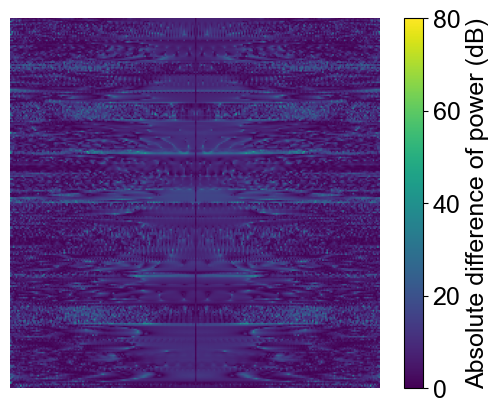

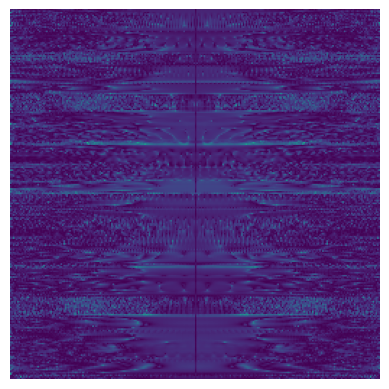

In [17]:
import os
import numpy as np
from glob import glob
from skimage import io
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

def watershed_segmentation(binary_img, kernel_size, min_distance):
    distance = ndi.distance_transform_edt(binary_img)
    coords = peak_local_max(distance,
                            footprint=np.ones((kernel_size, kernel_size)),
                            labels=binary_img,
                            min_distance=min_distance)#ball(radius=kernel_size)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=binary_img)
    return labels

def img_resize(image, resize):
    if len(image.shape) > 2:
        channel = image.shape[2]
        out = np.zeros((resize[0], resize[1], channel))
        for c in range(channel):
            image_c = Image.fromarray(image[:, :, c])
            if image_c.size[0] > resize[0] or image_c.size[1] > resize[1]:  # 縮小
                image_c = image_c.resize((resize[1], resize[0]))
            elif image_c.size[0] < resize[0] or image_c.size[1] < resize[1]:  # 拡大
                image_c = image_c.resize((resize[1], resize[0]), resample=Image.BICUBIC)
            out[:, :, c] = np.array(image_c)
    else:
        out = np.zeros((resize[0], resize[1]))
        image_c = Image.fromarray(image)
        if image_c.size[0] > resize[0] or image_c.size[1] > resize[1]:  # 縮小
            image_c = image_c.resize((resize[1], resize[0]))
        elif image_c.size[0] < resize[0] or image_c.size[1] < resize[1]:  # 拡大
            image_c = image_c.resize((resize[1], resize[0]), resample=Image.BICUBIC)
        out[:, :] = np.array(image_c)
    return out


def fourier_analysis(path, resize=(256,256), gt_mode=False):
    # settings
    ksize = 5
    sigma = 1.0
    truncate = ((ksize-1)/2-0.5)/sigma

    # load image
    img_raw = io.imread(path)
    img_raw_for_return = img_raw.copy()
    #img_raw_for_return = img_raw_for_return/65535
    #img_raw_for_return = img_raw_for_return.astype(np.uint8)
    if gt_mode:
        img_raw = img_resize(image=img_raw, resize=resize)
        img_raw_for_return = img_raw.copy()
        img_raw_for_return = img_raw_for_return.astype(np.uint16)
    assert img_raw.shape==resize, f'Shape not matched {img_raw.shape}:{resize}'

    # get power spectrum in frequency domain
    img = np.fft.fft(img_raw)
    img = np.fft.fftshift(img)
    pw_r = np.abs(img) ** 2
    pw = 10 * np.log10(pw_r + 1)

    return img_raw_for_return, pw

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 18
exp_name = 'trial_wellplate_epoch100_batch28'
id_name = 'r01c06f06p01'#'r14c02f04p01'#'r01c06f06p01'
test_name = 'U2OS_48h'
save_dir = f'./visualize_fourier_analysis/{exp_name}/{test_name}/{id_name}'
print(save_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

true_root = f'/Users/morikura/Documents/Ozeki/pairedimagetoimagetranslation/results/wsb/{exp_name}/train_fold1_20240301-012459/test/loss/images/{id_name}/GT'
true_img_paths = sorted(glob(f"{true_root}/*.tif"))
print(len(true_img_paths))

wsb_root = f'/Users/morikura/Documents/Ozeki/pairedimagetoimagetranslation/results/wsb/{exp_name}/train_fold1_20240301-012459/test/loss/images/{id_name}/Predict'
wsb_img_paths = sorted(glob(f"{wsb_root}/*.tif"))
print(len(wsb_img_paths))

pw_dict_gt = {}
pw_dict_pred = {}
for img_path in true_img_paths:
    img_raw, pw = fourier_analysis(path=img_path, gt_mode=True)
    filename = os.path.splitext(os.path.basename(img_path))[0]
    save_dir_each = f'{save_dir}/GT'
    if not os.path.exists(save_dir_each):
        os.makedirs(save_dir_each)

    fig = plt.figure()
    plt.imshow(img_raw, cmap='gray', vmin=0, vmax=65535)
    plt.axis('off')
    cbar = plt.colorbar(label='Intensity (-)')
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    cbar.ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
    #plt.savefig(f"{save_dir_each}/{filename}-raw.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-raw.pdf", bbox_inches="tight", dpi=600)
    plt.close()
    del fig

    fig = plt.figure()
    plt.imshow(pw, cmap='magma', vmin=0, vmax=130)
    plt.axis('off')
    plt.colorbar(label='Power (dB)')
    #plt.savefig(f"{save_dir_each}/{filename}-pw.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-pw.pdf", bbox_inches="tight", dpi=600)
    plt.close()
    del fig

    save_dir_each = f'{save_dir}/GT_no_colorbar'
    if not os.path.exists(save_dir_each):
        os.makedirs(save_dir_each)

    fig = plt.figure()
    plt.imshow(img_raw, cmap='gray', vmin=0, vmax=65535)
    plt.axis('off')
    # cbar = plt.colorbar(label='Intensity (-)')
    # cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    # cbar.ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
    #plt.savefig(f"{save_dir_each}/{filename}-raw.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-raw.pdf", bbox_inches="tight", dpi=600)
    plt.close()
    del fig

    fig = plt.figure()
    plt.imshow(pw, cmap='magma', vmin=0, vmax=130)
    plt.axis('off')
    # plt.colorbar(label='Power (dB)')
    #plt.savefig(f"{save_dir_each}/{filename}-pw.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-pw.pdf", bbox_inches="tight", dpi=600)
    plt.close()
    del fig

    pw_dict_gt[filename] = pw

for img_path in wsb_img_paths:
    img_raw, pw = fourier_analysis(path=img_path, gt_mode=True)
    filename = os.path.splitext(os.path.basename(img_path))[0]
    save_dir_each = f'{save_dir}/WSB'
    if not os.path.exists(save_dir_each):
        os.makedirs(save_dir_each)

    fig = plt.figure()
    plt.imshow(img_raw, cmap='gray', vmin=0, vmax=65535)
    plt.axis('off')
    cbar = plt.colorbar(label='Intensity (-)')
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    cbar.ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
    #plt.savefig(f"{save_dir_each}/{filename}-raw.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-raw.pdf", bbox_inches="tight", dpi=600)
    plt.close()
    del fig

    fig = plt.figure()
    plt.imshow(pw, cmap='magma', vmin=0, vmax=130)
    plt.axis('off')
    plt.colorbar(label='Power (dB)')
    #plt.savefig(f"{save_dir_each}/{filename}-pw.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-pw.pdf", bbox_inches="tight", dpi=600)
    plt.close()
    del fig

    save_dir_each = f'{save_dir}/WSB_no_colorbar'
    if not os.path.exists(save_dir_each):
        os.makedirs(save_dir_each)

    fig = plt.figure()
    plt.imshow(img_raw, cmap='gray', vmin=0, vmax=65535)
    plt.axis('off')
    # cbar = plt.colorbar(label='Intensity (-)')
    # cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    # cbar.ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
    #plt.savefig(f"{save_dir_each}/{filename}-raw.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-raw.pdf", bbox_inches="tight", dpi=600)
    plt.close()
    del fig

    fig = plt.figure()
    plt.imshow(pw, cmap='magma', vmin=0, vmax=130)
    plt.axis('off')
    # plt.colorbar(label='Power (dB)')
    #plt.savefig(f"{save_dir_each}/{filename}-pw.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-pw.pdf", bbox_inches="tight", dpi=600)
    plt.close()
    del fig

    pw_dict_pred[filename] = pw

for key in pw_dict_gt.keys():
    save_dir_each = f'{save_dir}/WSB'
    if not os.path.exists(save_dir_each):
        os.makedirs(save_dir_each)

    filename = key
    print(key)
    pw_gt = pw_dict_gt[key]
    pw_pred = pw_dict_pred[key]

    pw_diff = np.abs(pw_pred-pw_gt)
    print(np.max(pw_diff))

    fig = plt.figure()
    plt.imshow(pw_diff, cmap='viridis', vmin=0, vmax=80)
    plt.axis('off')
    plt.colorbar(label='Absolute difference of power (dB)')
    #plt.savefig(f"{save_dir_each}/{filename}-pw-diff-to-true.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-pw-diff-to-true.pdf", bbox_inches="tight", dpi=600)
    plt.show()
    del fig

    save_dir_each = f'{save_dir}/WSB_no_colorbar'
    if not os.path.exists(save_dir_each):
        os.makedirs(save_dir_each)

    fig = plt.figure()
    plt.imshow(pw_diff, cmap='viridis', vmin=0, vmax=80)
    plt.axis('off')
    # plt.colorbar(label='Absolute difference of power (dB)')
    #plt.savefig(f"{save_dir_each}/{filename}-pw-diff-to-true.png", bbox_inches="tight", dpi=600)
    plt.savefig(f"{save_dir_each}/{filename}-pw-diff-to-true.pdf", bbox_inches="tight", dpi=600)
    plt.show()
    del fig
    